In [1]:
#Import Packages

import numpy as np
from numpy import random as rd
from pykrx import stock
import scipy as sp
import pandas as pd
from scipy import optimize
import copy
import matplotlib.pyplot as plt

In [2]:
class Optima:
    def __init__(self):
        self.var_cov_mat = None
        self.rf = 0.015
        self.ret = None
        self.tickers = None
        self.data_start = None
        self.data_end = None
        self.N = None
        self.data = None
        
        self.tp = None # time Point
        self.windowLength = None
        
    def setTickers(self, tickers):
        self.tickers = tickers
        self.N = len(self.tickers)
    
    def setDataDate(self, srt, end):
        if type(srt) == str:
            self.data_start = srt
        else:
            self.data_start = str(srt)
        if type(end) == str:
            self.data_end = end
        else:
            self.data_end = str(end)
        
    def loadData(self):
        raw_data = []
        N = self.N
        for i in range(N):
            raw_data.append(stock.get_market_ohlcv_by_date(self.data_start, self.data_end, self.tickers[i])["종가"])
        self.data = pd.DataFrame(np.asarray(raw_data).T, columns = self.tickers, dtype=np.int32)
        self.ret = pd.DataFrame(np.nan, index=np.arange(self.data.shape[0]), columns=self.data.columns)
        for i in range(1, self.data.shape[0]):
            self.ret.iloc[i] = self.data.iloc[i]/self.data.iloc[i-1]
        self.var_cov_mat = np.identity(self.N)
    
    def gen_var_cov_mat(self):
        ret_tp = self.ret.iloc[self.tp - self.windowLength : self.tp]
        for i in range(0, self.N):
            for j in range(0, self.N):
                #print('-',end=' ')
                #print(np.cov(ret_tp.iloc[1:,i], ret_tp.iloc[1:,j])[0,1])
                self.var_cov_mat[i][j] = np.cov(ret_tp.iloc[1:,i], ret_tp.iloc[1:,j])[0,1]
    
    def setWindowLength(self, time):
        self.windowLength = time
    
    def setTimePoint(self, tp):
        self.tp = tp
        
    
    def eq_constraint(self, w):
        summation = 0
        for i in w:
            summation += i
            
        return summation - 1
    
    def flarray(self, w): #수익률도 전체 데이터가 아닌 특정기간의 수익률로 바꿔줘야함!!!!!
        ret_exd = np.cumprod(self.ret.iloc[self.tp - self.windowLength : self.tp]) - self.rf
        return -(np.dot(np.transpose(ret_exd.iloc[-1]), w) / (np.dot(np.dot(np.transpose(w), self.var_cov_mat), w))**(1/2))

    def Max_Sharp(self):
        return sp.optimize.fmin_slsqp(self.flarray, [1/self.N for i in range(self.N)], bounds=[(0,1) for i in range(self.N)], eqcons=[self.eq_constraint])
    
    
    def w(self):
        self.gen_var_cov_mat()
        return self.Max_Sharp()
    
    
    
    

In [3]:
optima = Optima()
tickers = ["002810", "003920", "004380", "011280"]#, "016580", "007340", "000370", "001510", "033270", "004710", "001500"]

optima.setTickers(tickers)
optima.setDataDate(20180101, 20191231)

optima.loadData()

optima.setWindowLength(30)
optima.setTimePoint(145)
optima.w()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -156.971630902948
            Iterations: 7
            Function evaluations: 50
            Gradient evaluations: 7


array([0.34638894, 0.43800272, 0.09406473, 0.12154362])

In [4]:
optima.setWindowLength(29)
optima.w()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -157.7021752684225
            Iterations: 7
            Function evaluations: 49
            Gradient evaluations: 7


array([0.33260327, 0.45340114, 0.09811513, 0.11588047])

In [8]:
rebal = pd.DataFrame(([1+np.random.randint(-10,12)*0.001 for i in range(6)] for i in range(333)))
rebal

,0,1,2,3,4,5
0,1.003,1.002,1.011,0.992,1.000,0.990
1,0.999,1.000,1.004,0.999,0.996,1.007
2,1.009,0.997,1.010,0.995,1.001,1.007
3,1.000,1.001,1.003,1.004,1.000,0.997
4,0.991,0.991,0.997,0.997,0.994,1.007
...,...,...,...,...,...,...
328,0.992,0.991,0.993,0.996,0.992,0.999
329,1.010,0.997,1.011,1.005,0.992,0.996
330,0.992,1.003,0.992,1.003,1.007,1.011
331,1.009,0.993,0.995,0.993,0.998,1.002


In [19]:
fr = 60
scalar = pd.DataFrame(index=range(0,rebal.shape[0]//fr+1))
scalar['k'] = 1

cumprod_DF = copy.deepcopy(rebal)

for i in range((rebal.shape[0]//fr)):#fr = 4 , range(0,2)
    for j in range(i*fr, (i+1)*fr):
    #    print(rebal.iloc[j:j+1].cumprod(), '********')
        cumprod_DF.append(rebal.iloc[i*fr :(i+1)*fr])
    cumprod_DF.iloc[i*fr:(i+1)*fr] = rebal.iloc[i*fr :(i+1)*fr].cumprod()
    if i != 0:
        #scalar['k'].iloc[i*fr:(i+1)*fr] = cumprod_DF.iloc[(i)*fr-1].sum()/cumprod_DF.shape[1]#이것도 실제로는 동일비중이 아니라, 특정 w벡터로 나눠줘야함.
        scalar['k'].iloc[i] = cumprod_DF.iloc[i*fr - 1].sum()/cumprod_DF.shape[1]
    #    print(i*fr, (i+1)*fr)
    #print('--------')
    #df.cumprod()[-1:].sum(axis=1)
    #print(df, 'asdfadfasdf')
    
if rebal.shape[0]%fr != 0:
    #print(rebal.iloc[-(rebal.shape[0]%fr):])
    mok = rebal.shape[0]//fr
    scalar['k'].iloc[-1 ] = cumprod_DF.iloc[(mok)*fr -1 ].sum()/cumprod_DF.shape[1]
    

cumprod_DF.head(33)

,0,1,2,3,4,5
0,1.003000,1.002000,1.011000,0.992000,1.000000,0.990000
1,1.001997,1.002000,1.015044,0.991008,0.996000,0.996930
2,1.011015,0.998994,1.025194,0.986053,0.996996,1.003909
3,1.011015,0.999993,1.028270,0.989997,0.996996,1.000897
4,1.001916,0.990993,1.025185,0.987027,0.991014,1.007903
5,1.012937,1.001894,1.030311,0.982092,0.992005,1.007903
6,1.004833,0.995883,1.034432,0.985038,0.995973,1.005887
7,1.013877,0.992895,1.040639,0.987993,0.992985,1.005887
8,1.017932,0.998852,1.035436,0.998861,0.991992,1.008905
9,1.008771,1.004845,1.026117,0.994866,0.991000,0.999825


In [9]:
scalar

,k
0,1.000000
1,0.997558
2,1.000724
3,0.996002
4,0.995932
5,0.997466
6,1.002615


In [232]:
#scalar의 마지막 값.
cumprod_DF.iloc[(mok)*fr -1 ].sum()/cumprod_DF.shape[1]

0.9958174294990091

In [233]:
scalar.iloc[1]

k    1.004335
Name: 1, dtype: float64

In [24]:
scalars = pd.DataFrame(index=range(0,rebal.shape[0]), columns=range(0,rebal.shape[1]))
for i in range(rebal.shape[0]//fr):
    scalars[0].iloc[i*fr : i*fr+fr] = float(scalar.iloc[i]) * float(scalar.iloc[i-1])
    if i == 0:
        scalars[0].iloc[i*fr : i*fr+fr] = 1
#for i in range(6):#rebal.shape[1]):
#    scalars[i].iloc[i:i+fr] = 3#scalar.iloc[i]

if rebal.shape[0]%fr != 0:#32개 중 마지막 2개에 대 한 처리
    print(rebal.iloc[-(rebal.shape[0]%fr):])
    mok = rebal.shape[0]//fr
    print(float(scalar.iloc[-1]))
    scalars[0].iloc[(mok)*fr : ] = float(scalar.iloc[-1])*float(scalar.iloc[-2])

for i in range(1,rebal.shape[1]):
    scalars[i] = scalars[i-1]
scalars.head(32)

         0      1      2      3      4      5
300  1.002  0.993  1.010  0.997  1.009  1.008
301  0.998  0.998  1.001  1.001  0.996  0.990
302  0.995  0.995  1.002  0.999  1.006  1.009
303  0.998  1.004  1.002  0.992  0.999  1.011
304  1.009  1.010  0.997  1.002  0.998  0.990
305  0.998  1.002  1.010  1.010  1.009  0.998
306  0.998  0.993  0.999  0.995  1.000  1.011
307  1.003  1.011  1.001  1.004  0.996  1.006
308  0.997  1.006  1.011  1.011  0.999  1.006
309  0.998  1.006  0.993  0.992  0.991  0.991
310  1.001  0.995  1.006  1.006  1.002  1.004
311  1.011  0.999  0.993  1.009  1.010  1.007
312  1.002  0.998  1.008  1.000  1.003  0.996
313  0.994  1.009  0.994  0.990  1.011  0.990
314  0.995  0.991  0.991  1.009  1.009  1.006
315  1.002  1.007  1.007  1.007  0.999  1.005
316  1.010  1.003  0.992  1.010  0.996  1.003
317  1.008  1.002  0.994  1.004  0.999  1.011
318  1.009  1.003  0.996  0.999  0.998  1.003
319  1.006  0.992  1.011  1.007  0.996  0.991
320  0.991  1.002  1.000  1.000  1

,0,1,2,3,4,5
0,1,1,1,1,1,1
1,1,1,1,1,1,1
2,1,1,1,1,1,1
3,1,1,1,1,1,1
4,1,1,1,1,1,1
5,1,1,1,1,1,1
6,1,1,1,1,1,1
7,1,1,1,1,1,1
8,1,1,1,1,1,1
9,1,1,1,1,1,1


In [266]:
scalars[0].cumprod()

0            1
1            1
2            1
3            1
4            1
        ...   
305    8.48003
306    8.49204
307    8.50406
308     8.5161
309    8.52815
Name: 0, Length: 310, dtype: object

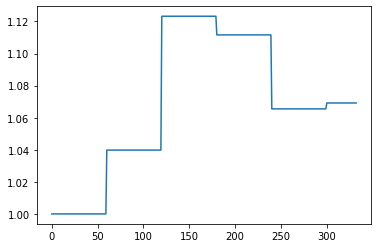

In [25]:
plt.figure()
plt.plot(scalars[0])
plt.show()

In [53]:
#scalar = scalar.cumprod() 이렇게하면 안되고, frequency마다 그전 거랑 곱해줘야됨.
for i in

In [144]:
cumprod_DF.sum(axis=1)/6 #실제로는 6으로 나누는 대신 w벡터들을 곱해줌.

0      1.000833
1      1.001013
2      1.004339
3      1.005358
4      1.005674
         ...   
995    1.005869
996    1.006330
997    1.008606
998    1.009436
999    1.010177
Length: 1000, dtype: float64

In [ ]:
########w_vectors ????? w * cumret * k = portfolio returns

In [16]:
cumprod_DF.iloc[7].sum()

6.029899468999999

In [26]:
ww=pd.DataFrame(([1/6 for i in range(6)] for i in range(rebal.shape[0])))
ww

,0,1,2,3,4,5
0,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
1,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
2,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
3,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
4,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
...,...,...,...,...,...,...
328,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
329,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
330,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
331,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667


array([1.])

In [267]:
testdf.iloc[1].sum()/6

1.0200000000000002

In [186]:
pd.DataFrame(w)

NameError: name 'w' is not defined

In [42]:
asdfasdf = pd.DataFrame(([3,3,3,'r'],[3,3,3,3]))
asdfasdff = pd.DataFrame(([4,4,4,4],[4,4,4,4,]))
asdfasdf*asdfasdff

,0,1,2,3
0,12,12,12,rrrr
1,12,12,12,12


In [166]:
scalar.iloc[400]

k    1.054182
Name: 400, dtype: float64

In [14]:
cumprod_DF

,0,1,2,3,4,5
0,0.993000,0.996000,1.003000,1.007000,1.000000,0.992000
1,0.989028,0.994008,1.005006,1.004986,0.997000,0.991008
2,0.995951,0.995002,1.013046,1.001971,0.987030,0.992990
3,0.993959,0.991022,1.011020,1.008985,0.981108,0.992990
4,0.986008,0.984085,1.018097,1.017057,0.977183,1.002920
5,0.996000,1.007000,0.995000,1.005000,0.990000,0.993000
6,1.000980,1.001965,1.002960,1.009020,0.987030,0.995979
7,0.995975,0.998959,1.009981,1.011038,0.979134,0.992991
8,0.989999,0.996961,1.002911,1.020137,0.984029,0.998949
9,0.980099,1.003940,1.011937,1.028298,0.978125,1.001946


In [174]:
scalar[598:603]

,k
598,1.054182
599,1.054182
600,1.141145
601,1.141145
602,1.141145


In [188]:
(ww * cumprod_DF * scalars).sum(axis=1)[590:610]

Series([], dtype: float64)

In [30]:
scalars.iloc[179:181]

,0,1,2,3,4,5
179,1.12327,1.12327,1.12327,1.12327,1.12327,1.12327
180,1.11164,1.11164,1.11164,1.11164,1.11164,1.11164


In [32]:
(ww * cumprod_DF * scalars).sum(axis=1)[179:181]

179    1.155882
180    1.110714
dtype: float64

In [62]:
scalar[19:23]

,k
19,1.000000
20,0.989824
21,0.979752
22,0.969782


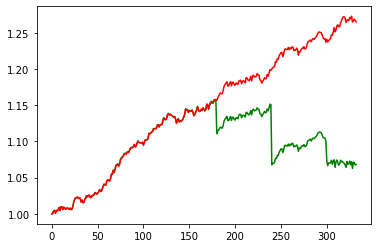

In [27]:
(ww * cumprod_DF * scalars).sum(axis=1)
import matplotlib.pyplot as plt
plt.figure()
plt.plot((ww * cumprod_DF * scalars).sum(axis=1), c='g')
#plt.plot((ww*cumprod_DF).sum(axis=1))
#리밸런싱을 안하면 cumprod_DF를 쓰는게 아니라 그냥 cumprod(testdf)하면 되는 거였음.
plt.plot(rebal.cumprod().sum(axis=1)/6, c='r')
plt.show()

In [97]:
(ww * cumprod_DF * scalars)

,0,1,2,3,4,5
0,0.199400,0.201400,0.199800,0.201200,0.198600,0.202000
1,0.199799,0.199990,0.199400,0.203011,0.196813,0.204222
2,0.200998,0.199790,0.200397,0.204026,0.197403,0.205039
3,0.199390,0.200589,0.199395,0.205250,0.199180,0.204424
4,0.202781,0.199559,0.199358,0.201170,0.203385,0.202580
...,...,...,...,...,...,...
95,0.200540,0.199960,0.204201,0.199758,0.201149,0.200556
96,0.198858,0.202059,0.199658,0.198258,0.200259,0.200459
97,0.200847,0.202059,0.200457,0.198853,0.200459,0.200058
98,0.202454,0.201251,0.201660,0.200841,0.202263,0.198257


In [198]:
testdf.cumprod().sum(axis=1)/6

,0,1,2,3,4,5,yes
0,0.997,0.996,1.010,0.992,0.998,1.000,605.293
1,0.996,1.006,1.010,1.005,0.998,1.007,608.222
2,0.990,1.002,1.000,1.001,0.997,1.008,605.798
3,0.997,0.999,0.995,0.997,1.007,1.006,606.101
4,0.990,1.009,0.996,1.004,1.000,1.006,606.505
...,...,...,...,...,...,...,...
95,0.996,1.003,0.990,0.992,0.995,0.996,603.172
96,0.996,0.999,0.997,0.991,1.004,0.992,603.879
97,1.002,1.009,1.001,1.008,0.994,1.005,607.919
98,1.000,1.001,1.009,1.008,0.995,0.990,606.303


In [210]:
aaaa.sum(axis=1)

0    6
1    9
2    7
dtype: int64

In [ ]:
asdfasdf

In [227]:
(testdf * ww).sum(axis=1)

0    1.174
1    1.224
2    1.136
3    1.196
4    1.268
5    1.214
6    1.170
7    1.208
8    1.244
9    1.190
dtype: float64

In [199]:
testdf

,0,1,2,3,4,5
0,0.98,0.90,1.05,0.98,0.95,1.01
1,0.97,1.08,0.99,0.95,1.11,1.02
2,0.98,0.91,0.95,0.96,0.96,0.92
3,0.96,1.00,0.95,0.98,1.02,1.07
4,1.09,1.05,1.06,1.10,1.05,0.99
5,1.05,1.03,0.96,1.05,0.90,1.08
6,1.11,1.08,0.94,0.90,0.90,0.92
7,1.07,1.03,0.92,0.98,1.10,0.94
8,1.02,1.01,1.09,1.09,1.00,1.01
9,0.98,0.90,1.09,0.99,1.00,0.99


In [124]:
testdf#.cumprod()

,0,1,2,3,4,5
0,1.00,0.94,0.94,1.02,0.94,1.05
1,1.02,1.02,1.02,1.04,1.07,0.97
2,1.08,0.99,0.96,1.03,1.02,1.05
3,1.09,0.91,1.01,0.94,0.95,0.96
4,1.05,0.97,0.92,0.99,1.09,1.04
5,1.11,1.05,0.93,1.02,1.00,1.09
6,0.92,1.03,1.11,1.04,1.09,1.07
7,1.05,1.05,0.91,1.09,1.08,0.93
8,0.90,1.07,0.91,0.91,1.09,0.93
9,0.97,1.10,1.00,0.94,0.97,1.11


In [79]:
cumprod_DF

""


# note below## note below## note below## note below## note below#
# note below## note below## note below## note below## note below#
# note below## note below## note below## note below## note below#
# note below## note below## note below## note below## note below#
# note below## note below## note below## note below## note below#
# note below## note below## note below## note below## note below#
# note below## note below## note below## note below## note below#
# note below## note below## note below## note below## note below#
# note below## note below## note below## note below## note below#
# note below## note below## note below## note below## note below#

In [39]:
testdf.iloc[0:2].sum(axis = 1)

0    6.03
1    6.11
dtype: float64

In [222]:
freq = 10
w = [1/5, 1/5, 1/5, 1/5, 1/5]

In [239]:
rebal.shape[0]%freq

8

In [243]:
a = np.asarray([1,2,3])
b = np.asarray([1,2,3])
a*b

array([1, 4, 9])

In [242]:
for i in range((rebal.shape[0]//freq)):
    df = rebal.iloc[i*freq :(i+1)*freq]
    print(df)
    
if rebal.shape[0]%freq != 0:
    print(rebal.iloc[-(rebal.shape[0]%freq):])


      0     1     2     3     4     5
0  1.02  0.93  0.95  0.99  1.02  0.95
1  1.05  0.94  1.05  1.11  1.11  1.03
2  0.97  1.05  0.98  1.02  0.99  1.04
3  0.90  0.99  1.09  1.11  1.08  0.97
4  0.96  1.03  0.97  1.01  0.99  1.10
5  0.95  1.08  0.94  0.90  0.90  1.00
6  0.92  1.07  0.97  1.08  1.06  0.99
7  0.99  1.09  1.10  1.07  0.94  1.11
8  0.99  1.01  1.07  0.97  0.98  0.97
9  1.01  1.03  1.08  1.06  1.04  0.97
       0     1     2     3     4     5
10  1.09  0.93  1.03  1.07  1.01  0.94
11  0.97  1.04  1.02  0.91  0.91  1.04
12  0.93  1.09  0.93  0.91  0.97  1.00
13  1.04  0.97  1.00  1.06  1.03  1.05
14  1.01  0.90  0.98  1.01  1.02  0.91
15  0.99  0.90  1.05  1.08  1.01  1.08
16  1.04  0.91  1.04  0.98  0.96  0.93
17  1.00  1.07  1.10  0.93  0.96  0.94
18  1.11  1.10  0.97  0.98  0.92  0.91
19  1.06  1.02  0.92  1.03  1.07  1.09
       0     1     2     3     4     5
20  0.93  0.98  1.00  1.01  1.07  0.90
21  1.11  0.95  1.08  0.95  1.11  0.94
22  0.93  0.95  0.96  0.98  1.00  1.

In [120]:
rebal.iloc[5:10].cumprod()

,0,1,2,3,4,5
5,1.060000,1.100000,0.910000,1.04000,0.960000,1.000000
6,1.134200,1.133000,0.819000,0.98800,0.892800,0.940000
7,1.100174,1.178320,0.794430,1.07692,0.964224,0.921200
8,1.045165,1.225453,0.714987,1.07692,0.896728,0.985684
9,1.076520,1.127417,0.779336,1.07692,0.941565,0.965970


In [119]:
rebal.iloc[1:5].cumprod()

,0,1,2,3,4,5
1,1.070000,0.900000,0.900000,1.020000,1.030000,0.900000
2,0.984400,0.882000,0.810000,0.948600,0.999100,0.819000
3,1.092684,0.943740,0.801900,1.033974,1.059046,0.761670
4,1.212879,0.972052,0.745767,0.982275,1.016684,0.845454


In [121]:
rebal.head(11)

,0,1,2,3,4,5
0,1.00,0.94,0.94,1.02,0.94,1.05
1,1.02,1.02,1.02,1.04,1.07,0.97
2,1.08,0.99,0.96,1.03,1.02,1.05
3,1.09,0.91,1.01,0.94,0.95,0.96
4,1.05,0.97,0.92,0.99,1.09,1.04
5,1.11,1.05,0.93,1.02,1.00,1.09
6,0.92,1.03,1.11,1.04,1.09,1.07
7,1.05,1.05,0.91,1.09,1.08,0.93
8,0.90,1.07,0.91,0.91,1.09,0.93
9,0.97,1.10,1.00,0.94,0.97,1.11


In [34]:
pd.DataFrame.cumsum(rebal.cumprod().iloc[-1])[-1:]/5

5    1.617605
Name: 111, dtype: float64

In [134]:
rebal.cumprod().iloc[-1]

0    3.541576
1    0.591426
2    0.583374
3    1.051113
4    4.484368
5    1.611752
Name: 99, dtype: float64

In [205]:
aaaa = pd.DataFrame(([1,2,3],[2,2,5],[3,2,2]))

In [206]:
aaaa

,0,1,2
0,1,2,3
1,2,2,5
2,3,2,2


In [207]:
aaaa.cumprod()

,0,1,2
0,1,2,3
1,2,4,15
2,6,8,30


In [208]:
aaaa.cumprod().sum(axis=1)

0     6
1    21
2    44
dtype: int64

In [211]:
aaaa.sum(axis=1)

0    6
1    9
2    7
dtype: int64